# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

In [4]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 26s, sys: 1.06 s, total: 1min 27s
Wall time: 1min 27s


In [6]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 53.4 s, sys: 568 ms, total: 54 s
Wall time: 54 s


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [10]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 6,575 training samples, 731 testing samples'

## Median absolute deviation feature selection

In [11]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [12]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [13]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 12.9 s, sys: 11.1 s, total: 24 s
Wall time: 42.5 s


In [14]:
clf_grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1}

In [15]:
best_clf

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.1, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='elasticnet', power_t=0.5,
       random_state=0, shuffle=True, verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [16]:
cv_result_df = pd.concat([
    pd.DataFrame(clf_grid.cv_results_),
    pd.DataFrame.from_records(clf_grid.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,alpha,l1_ratio
0,0.175844,0.054309,0.845850,0.886458,1e-06,0,"{'l1_ratio': 0, 'alpha': 1e-06}",40,0.817642,0.870788,0.871388,0.895376,0.848546,0.893209,0.028594,0.004438,0.022026,0.011116,0.000001,0.00
1,0.329357,0.022195,0.837063,0.878728,1e-06,0.05,"{'l1_ratio': 0.05, 'alpha': 1e-06}",50,0.828018,0.891228,0.844528,0.870101,0.838650,0.874855,0.042428,0.012548,0.006833,0.009050,0.000001,0.05


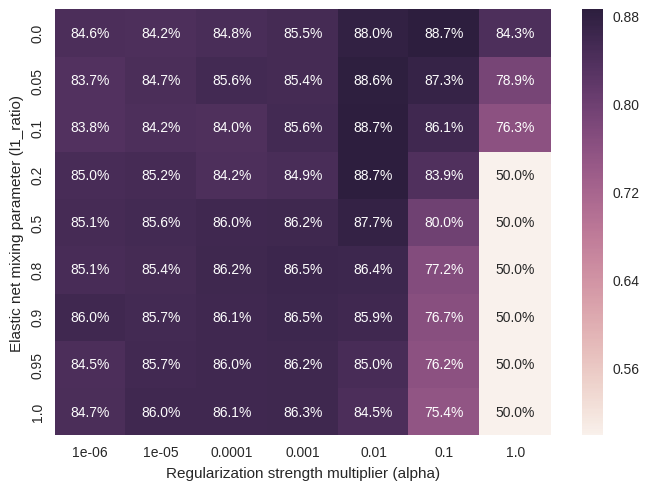

In [17]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [18]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

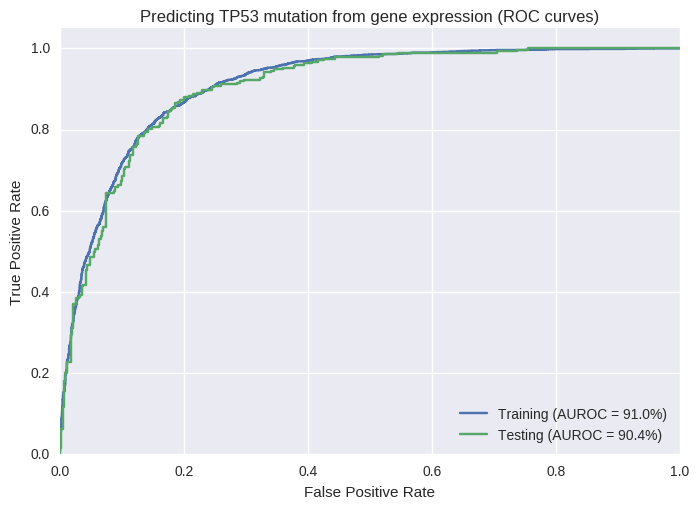

In [19]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [20]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [21]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'43.0% zero coefficients; 131 negative and 154 positive coefficients'

In [22]:
coef_df.head(10)

,weight,abs
2525,0.320822,0.320822
4316,0.316326,0.316326
7499,-0.316097,0.316097
3899,-0.307478,0.307478
81607,-0.299384,0.299384
23120,0.295043,0.295043
57512,0.290986,0.290986
1907,-0.278645,0.278645
642587,-0.274429,0.274429
79679,0.257771,0.257771


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. This makes finding a transcriptional signature fairly easy. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...

## Investigate the predictions

In [23]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [24]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-70-6722-01,TCGA-70-6722-01,0,0,5.010120,0.993374,99.3%
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,4.873791,0.992414,99.2%
TCGA-49-6743-01,TCGA-49-6743-01,0,0,4.604212,0.990090,99.0%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,4.497534,0.988986,98.9%
TCGA-55-6978-01,TCGA-55-6978-01,0,0,4.464442,0.988620,98.9%
TCGA-13-0897-01,TCGA-13-0897-01,1,0,4.152361,0.984516,98.5%
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,4.112075,0.983890,98.4%
TCGA-23-1027-01,TCGA-23-1027-01,0,0,3.929980,0.980734,98.1%
TCGA-AO-A0JE-01,TCGA-AO-A0JE-01,0,0,3.877245,0.979712,98.0%


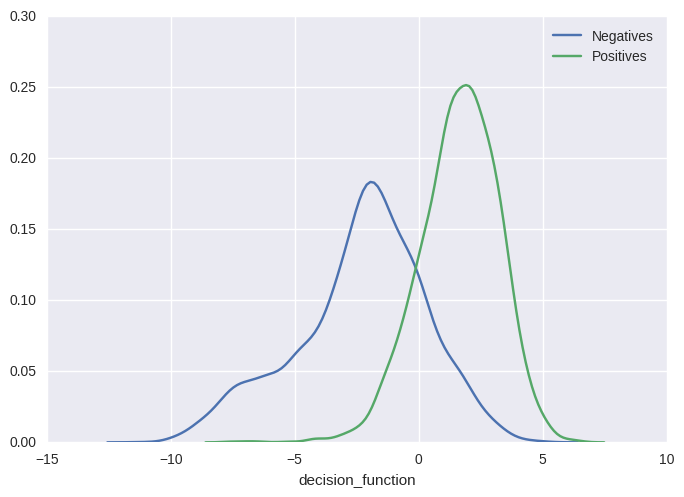

In [25]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

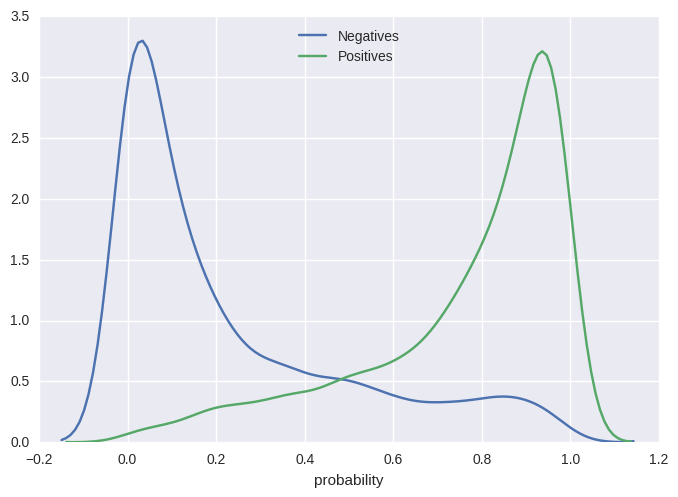

In [26]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')